In [1]:
import tensorflow as tf
from keras.layers import (
    Dense,
    Input,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization,
    UpSampling2D,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Flatten,
    Concatenate,
)
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.models import Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow import keras

# import tensorflow_model_optimization as tfmot
from keras import backend as K
from tqdm import tqdm
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
from module.const import *
from module import func, loss
import random

# データセット作成

  0%|          | 0/1080 [00:00<?, ?it/s]

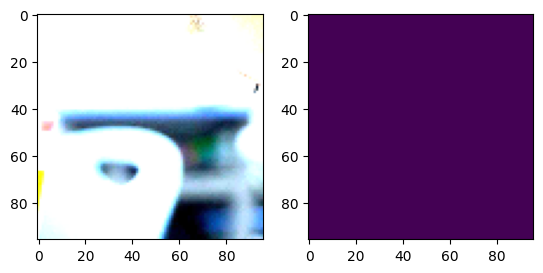

  0%|          | 1/1080 [00:00<04:44,  3.80it/s]

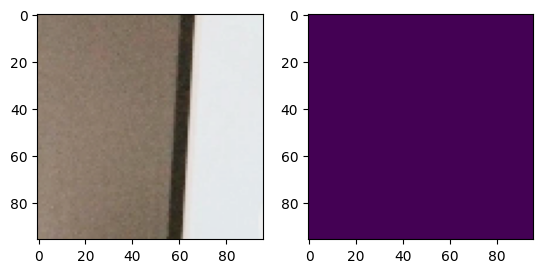

  0%|          | 2/1080 [00:00<03:51,  4.65it/s]

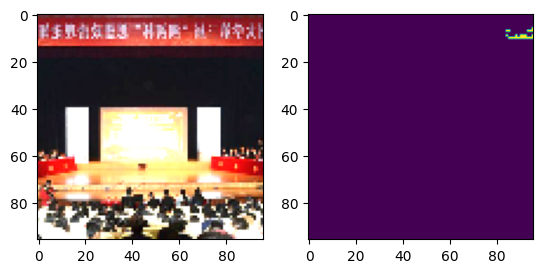

  0%|          | 3/1080 [00:00<03:29,  5.14it/s]

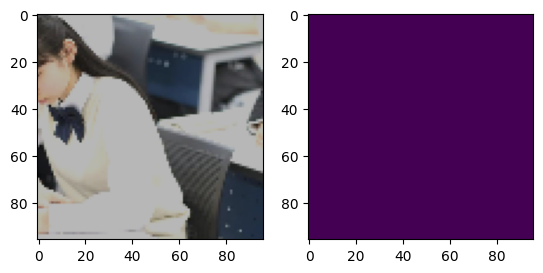

  0%|          | 4/1080 [00:00<03:16,  5.47it/s]

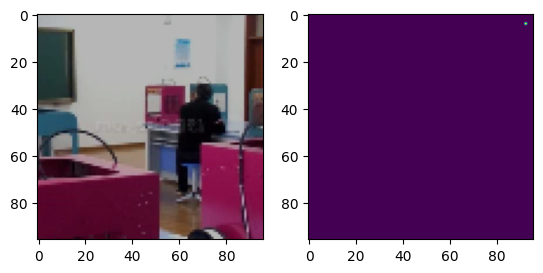

  0%|          | 5/1080 [00:00<03:11,  5.61it/s]

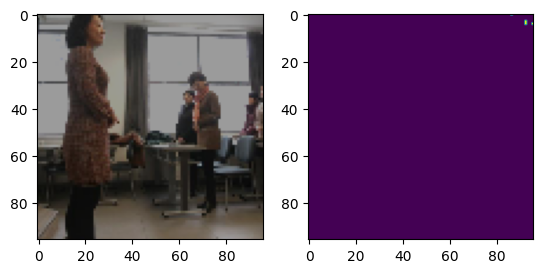

  1%|          | 6/1080 [00:01<03:09,  5.65it/s]

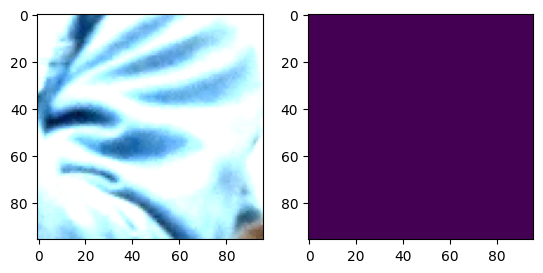

  1%|          | 7/1080 [00:01<03:06,  5.77it/s]

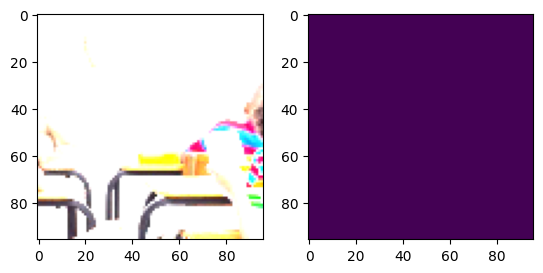

  1%|          | 8/1080 [00:01<03:01,  5.91it/s]

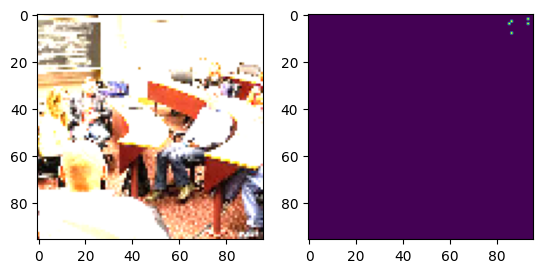

  1%|          | 9/1080 [00:01<02:58,  5.99it/s]

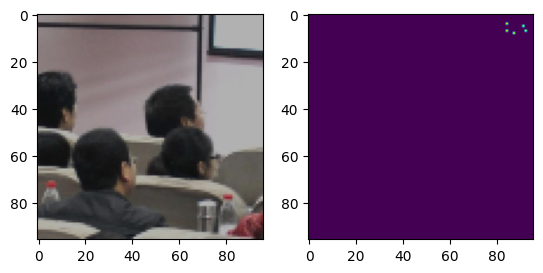

  1%|          | 10/1080 [00:01<03:01,  5.90it/s]

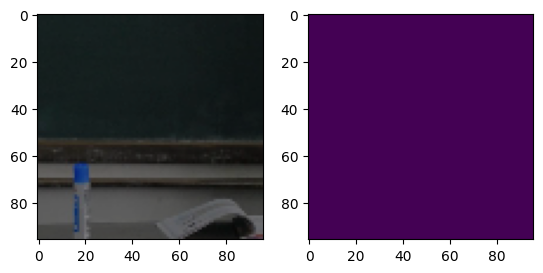

  1%|          | 11/1080 [00:01<03:00,  5.92it/s]

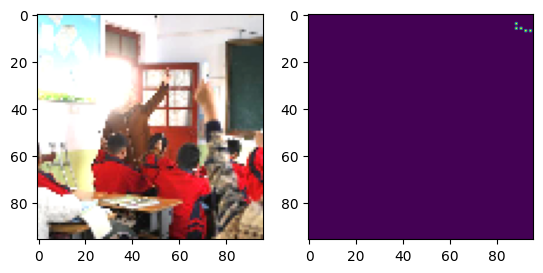

  1%|          | 12/1080 [00:02<03:03,  5.83it/s]

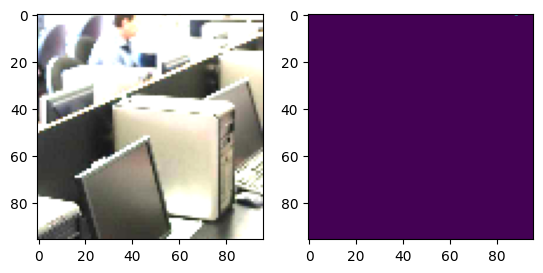

  1%|          | 13/1080 [00:02<03:04,  5.79it/s]

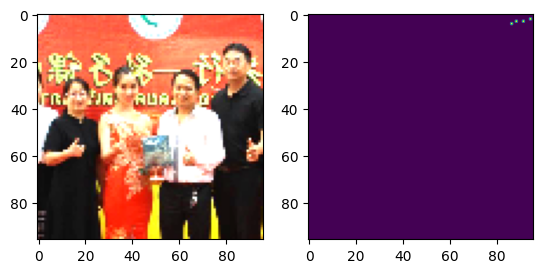

  1%|▏         | 14/1080 [00:02<03:36,  4.93it/s]

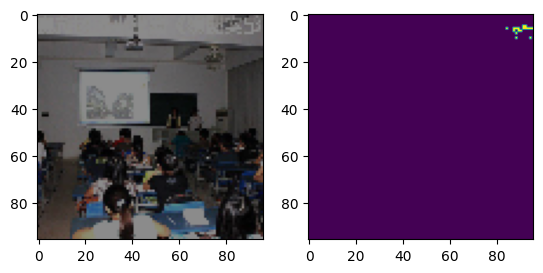

  1%|▏         | 15/1080 [00:02<03:27,  5.14it/s]

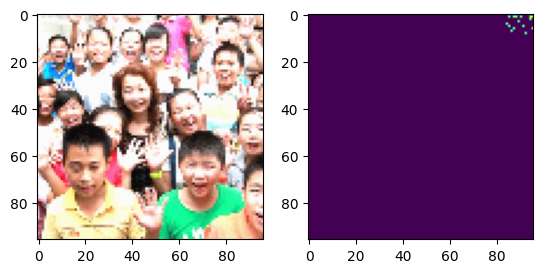

  1%|▏         | 16/1080 [00:02<03:20,  5.31it/s]

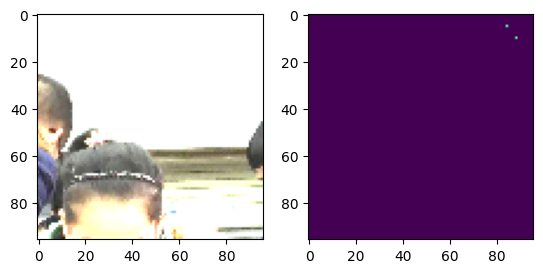

  2%|▏         | 17/1080 [00:03<03:11,  5.55it/s]

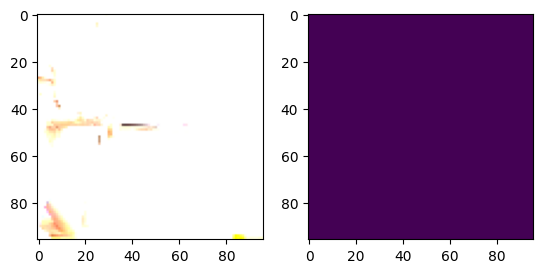

  2%|▏         | 18/1080 [00:03<03:06,  5.71it/s]

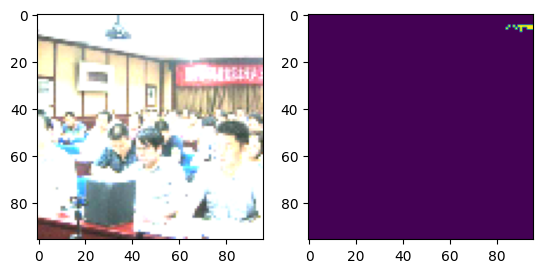

  2%|▏         | 19/1080 [00:03<03:02,  5.81it/s]

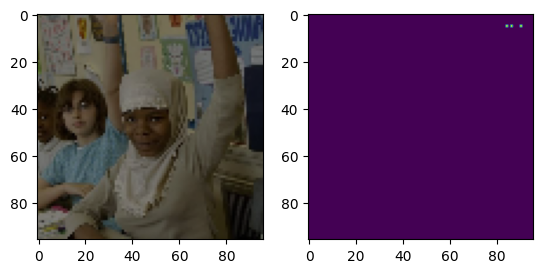

  2%|▏         | 20/1080 [00:03<03:03,  5.77it/s]

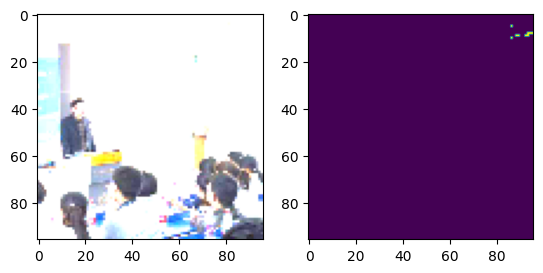

  2%|▏         | 21/1080 [00:03<03:02,  5.81it/s]

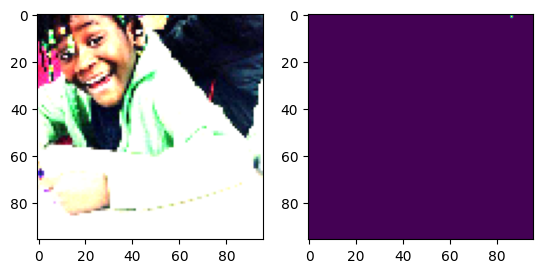

  2%|▏         | 22/1080 [00:03<02:59,  5.90it/s]

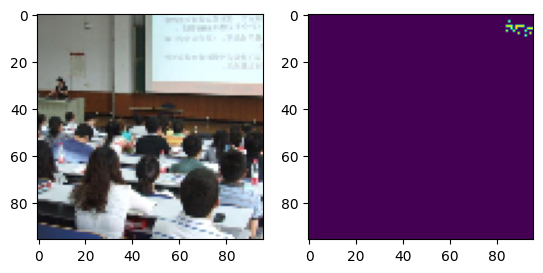

  2%|▏         | 23/1080 [00:04<03:00,  5.87it/s]

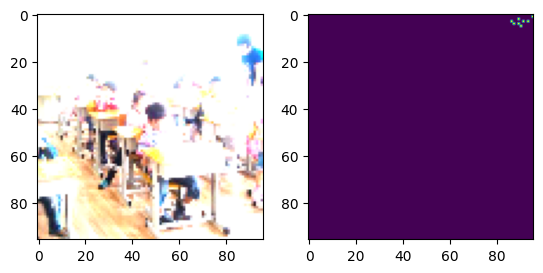

  2%|▏         | 24/1080 [00:04<02:57,  5.94it/s]

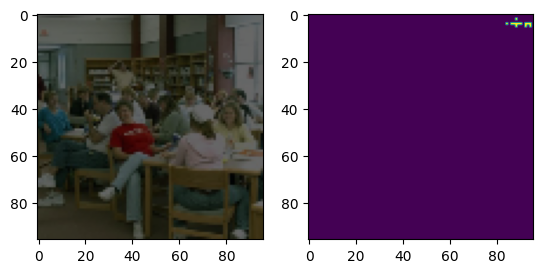

  2%|▏         | 25/1080 [00:04<02:59,  5.88it/s]

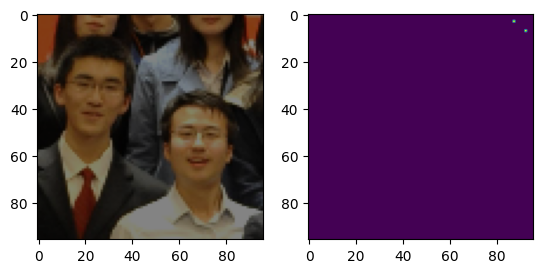

  2%|▏         | 26/1080 [00:04<03:05,  5.69it/s]

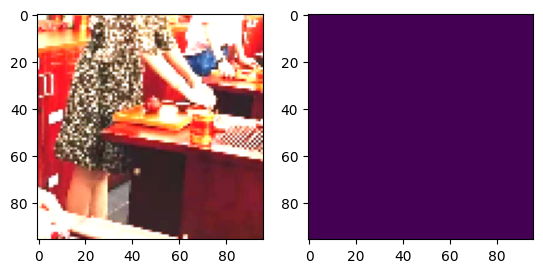

  2%|▎         | 27/1080 [00:04<03:05,  5.68it/s]

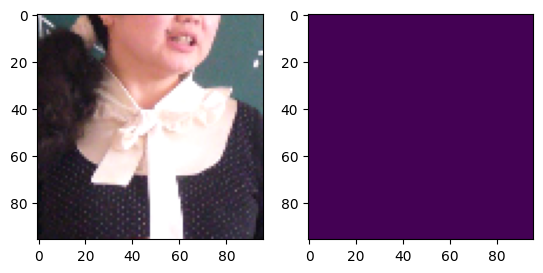

  3%|▎         | 28/1080 [00:05<03:38,  4.82it/s]

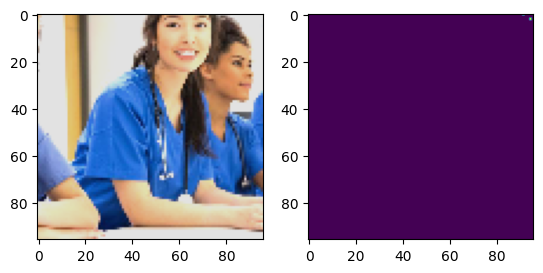

  3%|▎         | 29/1080 [00:05<03:26,  5.08it/s]

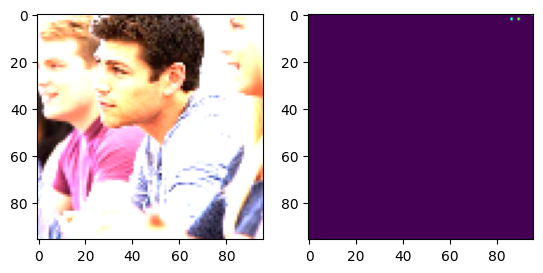

  3%|▎         | 30/1080 [00:05<03:18,  5.29it/s]

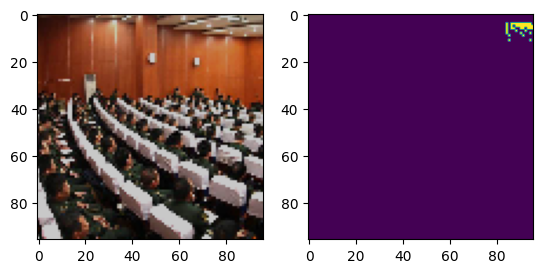

  3%|▎         | 31/1080 [00:05<03:12,  5.44it/s]

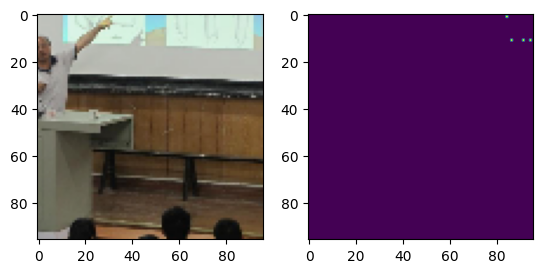

  3%|▎         | 32/1080 [00:05<03:15,  5.35it/s]

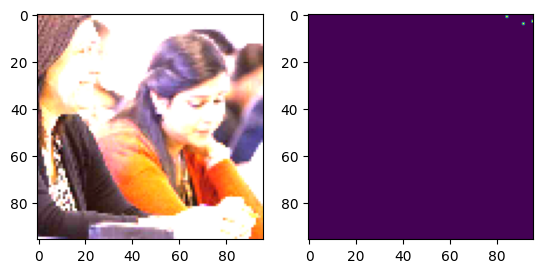

  3%|▎         | 33/1080 [00:05<03:09,  5.52it/s]


KeyboardInterrupt: 

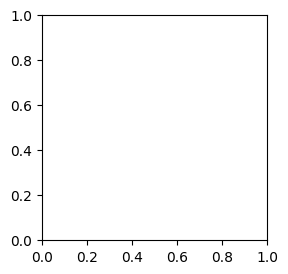

In [2]:
# データセット
x_train = []
y_train = []
x_test = []
y_test = []
x_valid = []
y_valid = []
semantic_label_size = INPUT_SIZE
trans_lst = []
center = (INPUT_SIZE[0] / 2, INPUT_SIZE[1] / 2)
scale = 1.0
for i in [theta for theta in range(0, 180, 10)]:
    trans_lst.append(cv2.getRotationMatrix2D(center, i, scale))

    # for dir in ["train", "valid"]:
dataset = []
for path in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, path)
    with h5py.File(path, "r") as f:
        img = f["img"][:]
        label = f["label"][:]
    dataset.append((img, label))
random_idx = list(range(0, len(dataset)))

# データをランダムに取得するためのインデックス
random.shuffle(random_idx)
# データ取得。データ数が少ないため、auguentationを行う。回転、反転、明るさ調整を行い、学習データに追加。
positive_count = 0
for i, idx in enumerate(tqdm(random_idx)):
    img, label = dataset[idx]
    if i < len(random_idx) * 0.9:
        if np.any(label == 1):
            positive_count += 1
        # else:
        #     continue
        for trans in trans_lst:
            img_trans = cv2.warpAffine(img, trans, semantic_label_size)
            label_trans = cv2.warpAffine(label, trans, semantic_label_size)
            img_trans = func.augment_brightness(img_trans)
            x_train.append(img_trans)
            y_train.append(cv2.resize(label_trans, semantic_label_size))
            img_trans = np.fliplr(img_trans)
            img_trans = func.augment_brightness(img_trans)
            x_train.append(img_trans)
            y_train.append(cv2.resize(np.fliplr(label_trans), semantic_label_size))
        # img_trans = img
        # img_trans = func.augment_brightness(img_trans)
        # x_train.append(img_trans)
        # y_train.append(cv2.resize(label, semantic_label_size))
        # img_trans = np.fliplr(img_trans)
        # img_trans = func.augment_brightness(img_trans)
        # x_train.append(img_trans)
        # y_train.append(cv2.resize(np.fliplr(label), semantic_label_size))
    else:
        x_valid.append(img)
        y_valid.append(cv2.resize(label, semantic_label_size))

3888 108


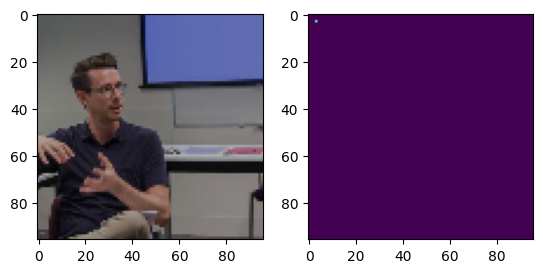

In [6]:
print(len(x_train), len(x_valid))
plt.subplot(1, 2, 1)
plt.imshow(x_train[0])
plt.subplot(1, 2, 2)
plt.imshow(y_train[0])
plt.show()

In [4]:

x_train = np.array(x_train) / 255
y_train = np.array(y_train)
x_test = np.array(x_test) / 255
y_test = np.array(y_test)
x_valid = np.array(x_valid) / 255
y_valid = np.array(y_valid)

# モデルの定義

In [5]:

mobilenet = MobileNetV2(
    input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], INPUT_CHANNEL),
    include_top=False,
    alpha=ALPHA,
    weights="imagenet",
)
mobilenet.summary()
complessed_mobilenet = Model(
    inputs=mobilenet.input, outputs=mobilenet.get_layer("block_6_expand_relu").output
)
for layer in complessed_mobilenet.layers:
    layer.trainable = False


semantic_model= tf.keras.models.Sequential(
    [
        complessed_mobilenet,
        Conv2D(
            filters=32,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        Conv2D(
            filters=32,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        Conv2D(
            filters=1,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="sigmoid",
        ),
        tf.keras.layers.UpSampling2D(size=(2,2), interpolation="bilinear"), # 24
        Conv2D(
            filters=64,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=(2,2), interpolation="bilinear"),# 48
        Conv2D(
            filters=32,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=(2,2), interpolation="bilinear"),# 96
        Conv2D(
            filters=1,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="sigmoid",
        ),]

)

semantic_model.summary()

Model: "mobilenetv2_0.75_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 24)   648         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 24)   96          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 24)   0           ['bn_Conv1[0][0]']               
                                                                                

# 学習

In [6]:
semantic_model.compile(
    loss=loss.DiceLoss,
    optimizer=Adam(learning_rate=0.001),
    metrics=[loss.IoU],
)

semantic_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
135/135 [==============================] - 5s 12ms/step - loss: 0.7559 - IoU: 0.1427 - val_loss: 0.9899 - val_IoU: 0.0051
Epoch 2/50
135/135 [==============================] - 1s 8ms/step - loss: 0.3674 - IoU: 0.4681 - val_loss: 1.0000 - val_IoU: 5.7714e-06
Epoch 3/50
135/135 [==============================] - 1s 8ms/step - loss: 0.2490 - IoU: 0.6019 - val_loss: 1.0000 - val_IoU: 6.6521e-06
Epoch 4/50
135/135 [==============================] - 1s 8ms/step - loss: 0.2283 - IoU: 0.6289 - val_loss: 0.7093 - val_IoU: 0.1701
Epoch 5/50
135/135 [==============================] - 1s 8ms/step - loss: 0.2177 - IoU: 0.6430 - val_loss: 0.3121 - val_IoU: 0.5243
Epoch 6/50
135/135 [==============================] - 1s 8ms/step - loss: 0.2120 - IoU: 0.6506 - val_loss: 0.1992 - val_IoU: 0.6678
Epoch 7/50
135/135 [==============================] - 1s 9ms/step - loss: 0.2068 - IoU: 0.6576 - val_loss: 0.2384 - val_IoU: 0.6149
Epoch 8/50
135/135 [==============================] - 1s 8ms/step -

# テスト

In [7]:
import shutil
test_img_lst = os.listdir("test")
test_result_dir = "test_result"
if os.path.exists(test_result_dir):
    shutil.rmtree(test_result_dir)
os.mkdir(test_result_dir)

In [8]:

for i, img_name in enumerate(test_img_lst):
    img_path = os.path.join("test", img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, INPUT_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    pred = semantic_model.predict(img)
    pred = np.squeeze(pred)
    pred = np.where(pred > 0.5, 1, 0)
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.subplot(1, 2, 2)
    plt.imshow(pred)
    plt.savefig(os.path.join(test_result_dir, img_name))
    plt.close()

# モデルの変換
### 粗いセグメンテーションを実装するために、モデルを途中でちょん切る

In [9]:
def get_name_spresense_output_layer(model, idx_ketu):
    layer_name = model.layers[idx_ketu].name
    return layer_name

spresense_output_layer_name = get_name_spresense_output_layer(semantic_model, 5)
spresense_output_layer_name

'conv2d_2'

In [10]:

semantic_model.summary()
spresense_model = Model(
    inputs=semantic_model.input, outputs=semantic_model.get_layer(spresense_output_layer_name).output
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 12, 12, 144)       48928     
                                                                 
 conv2d (Conv2D)             (None, 12, 12, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        1056      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 1)         3

In [16]:

test_sprit_result_dir = "test_sprit_result" 
if os.path.exists(test_sprit_result_dir):
    shutil.rmtree(test_sprit_result_dir)
os.mkdir(test_sprit_result_dir)
for img_name in test_img_lst[::-1 ]:
    img_path = os.path.join("test", img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, INPUT_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    pred = spresense_model.predict(img)
    pred = np.squeeze(pred)
    # pred_stats = scipy.stats.describe(pred, axis=None)
    mask_pred = np.where(pred >0.5, 1, 0)
    plt.subplot(1, 3, 1)
    plt.imshow(img[0])
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred)
    plt.subplot(1, 3, 3)
    plt.imshow(pred, vmin=0, vmax=1)
    # cbar = plt.colorbar(pred, ax=plt.gca())
    # cbar.set_label('Colorbar Label')  # カラーバーのラベルを設定
    # plt.show()
    plt.savefig(os.path.join(test_sprit_result_dir, img_name))
    plt.close()

# spresense用にモデル変換

In [17]:

if os.path.exists(MODEL_DIR) == False:
    os.mkdir(MODEL_DIR)
spresense_model.save(FULL_MODEL_PATH)
conveter = tf.lite.TFLiteConverter.from_keras_model(spresense_model)
tflite_model = conveter.convert()
float_model_size = len(tflite_model) / 1024 / 1024
print(f"float model size: {float_model_size} MB")
open(TFLITE_MODEL_PATH, "wb").write(tflite_model)


import binascii


def convert_to_c_array(bytes) -> str:
    hexstr = binascii.hexlify(bytes).decode("UTF-8")
    hexstr = hexstr.upper()
    array = ["0x" + hexstr[i : i + 2] for i in range(0, len(hexstr), 2)]
    array = [array[i : i + 10] for i in range(0, len(array), 10)]
    return ",\n  ".join([", ".join(e) for e in array])


tflite_binary = open(TFLITE_MODEL_PATH, "rb").read()
ascii_bytes = convert_to_c_array(tflite_binary)
header_file = (
    "const unsigned char model_tflite[] = {\n  "
    + ascii_bytes
    + "\n};\nunsigned int model_tflite_len = "
    + str(len(tflite_binary))
    + ";"
)
# print(c_file)
open(HEADER_MODEL_PATH, "w").write(header_file)
open(SPRESENSE_HEADER_MODEL_PATH, "w").write(header_file)

INFO:tensorflow:Assets written to: C:\Users\oosim\AppData\Local\Temp\tmphr9_l2yo\assets


INFO:tensorflow:Assets written to: C:\Users\oosim\AppData\Local\Temp\tmphr9_l2yo\assets


float model size: 0.20481491088867188 MB


1331618

In [18]:
print("--------start quantization--------")


def representative_dataset_gen():
    for i in range(len(x_valid)):
        input_image = tf.cast(x_valid[i], tf.float32)
        input_image = tf.reshape(
            input_image, [1, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_CHANNEL]
        )
        yield ([input_image])


converter = tf.lite.TFLiteConverter.from_keras_model(spresense_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_quant_model_path = os.path.join(MODEL_DIR, "model_quant.tflite")
with open(tflite_quant_model_path, "wb") as f:
    f.write(tflite_quant_model)
spresense_quant_model_path = os.path.join(MODEL_DIR, "spresense_model_quant.h")
tflite_binary = open(tflite_quant_model_path, "rb").read()
ascii_bytes = convert_to_c_array(tflite_binary)
header_file = (
    "const unsigned char model_tflite[] = {\n  "
    + ascii_bytes
    + "\n};\nunsigned int model_tflite_len = "
    + str(len(tflite_binary))
    + ";"
)

open(HEADER_QUANT_MODEL_PATH, "w").write(header_file)
open(SPRESENSE_HEADER_QUANT_MODEL_PATH, "w").write(header_file)


--------start quantization--------
INFO:tensorflow:Assets written to: C:\Users\oosim\AppData\Local\Temp\tmp7bydpvr5\assets


INFO:tensorflow:Assets written to: C:\Users\oosim\AppData\Local\Temp\tmp7bydpvr5\assets
c:\Users\oosim\Anaconda3\envs\fuc\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


713378